In [1]:
import numpy as np
import random
import torch

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt 
import matplotlib as mpl
from cycler import cycler

import csv
import pandas as pd 

from collections import Counter
import string
from torch.nn.utils.rnn import pad_sequence

import re

import neuralnetworks 
import analysis_tools 



font = {'family' : 'Tahoma',
        'size'   : 15}
mpl.rc('font', **font) 
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])

mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10)

## Reading the data 

In [3]:
data_path = '/Users/ilseplaisier/Documents/Machine_Learning/ml-example/ag-news-classification-dataset/'
train_csv = data_path+'train.csv'
test_csv = data_path+'test.csv'

# check data
# Class Index,Title,Description
df_train = pd.read_csv(train_csv)
#df_train.head()
#we want to use both title and description
df_new = df_train.copy()
df_new['Text'] = df_train['Title']+df_train['Description']
df_new.drop(columns = ['Title', 'Description'], inplace = True)

df_test = pd.read_csv(test_csv)
df_val = df_test.copy()
df_val['Text'] = df_test['Title']+df_test['Description']
df_val.drop(columns = ['Title', 'Description'], inplace = True)
#df_new_test['Class Index'].value_counts()

x_train = df_new['Text']
y_train = df_new['Class Index']

x_test = df_val['Text']
y_test = df_val['Class Index']

x_test.head(10)




0    Fears for T N pension after talksUnions repres...
1    The Race is On: Second Private Team Sets Launc...
2    Ky. Company Wins Grant to Study Peptides (AP)A...
3    Prediction Unit Helps Forecast Wildfires (AP)A...
4    Calif. Aims to Limit Farm-Related Smog (AP)AP ...
5    Open Letter Against British Copyright Indoctri...
6    Loosing the War on Terrorism\\"Sven Jaschan, s...
7    FOAFKey: FOAF, PGP, Key Distribution, and Bloo...
8    E-mail scam targets police chiefWiltshire Poli...
9    Card fraud unit nets 36,000 cardsIn its first ...
Name: Text, dtype: object

## Data processing

To process the data, we convert out review consisting of strings to lists with numbers. We identify each unique word to a number. Before we do this, we first clean the data; we remove all numbers and punctuation. Lastly, we pad the data of each batch to the same length by adding zeros. 

In [4]:



class clean_up_data():
   
    def tokenize(self, data):
        tokenized_data = data.str.split().copy()
        return tokenized_data 
    
    def lower_capital_letters(self, data):
        data = [[word.lower() for word in sentence]for sentence in data]
        return data 
    
    def remove_characters(self, data):
        data = [[word for word in sentence if not re.search(r'\\', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'\d', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'\)', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'-', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'\.', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'-', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r',', word)]for sentence in data]

        return data

    def remove_punctuation(self, data):
        data = [[token for token in sentence if token not in string.punctuation] for sentence in data]
        return data 

    def clean_data(self, data):
        data = self.tokenize(data)
        data = self.lower_capital_letters(data)
        data = self.remove_characters(data)
        data = self.remove_punctuation(data)
        return data 

    
class processing_the_data():

    def create_word_to_idx(self, data):
        word_to_idx = {}
        for i, word in enumerate(Counter(self.flatten(data))):
            word_to_idx[word] =  i
            self.word_to_idx = word_to_idx 
       
    def flatten(self, data):
        return [x for xs in data for x in xs]
        
    def vectorize(self, tokenized_data):
        vec_data = tokenized_data.copy()
        for l, line in enumerate(tokenized_data):
            for w, word in enumerate(line):
                if self.word_to_idx.get(word) is not None:
                    vec_data[l][w] = self.word_to_idx[word] # if word not exist for test data, add a zero. we create the dictionairy only based on training data 
                else:
                    vec_data[l][w] = 0 
                    print(f"\n {word} was not in the dictionary, added a zero")
        return vec_data 
        


    def process_data(self, data):
        vectorized_data = self.vectorize(data)
        return vectorized_data 







In [ ]:


#clean up data 
c = clean_up_data()
print("cleaning the training data...")
train_data = c.clean_data(x_train)
print("cleaning the test data...")
test_data = c.clean_data(x_test)

#create word to idx
print('create vocabulary dictionary...')
p = processing_the_data()
p.create_word_to_idx(train_data)# create vocabulary only on training data 

#process data 
print("process the training data...")
x_train_proc = p.process_data(train_data)
print("process the testing data...")
x_test_proc = p.process_data(test_data)
    

cleaning the training data...
cleaning the test data...


In [12]:

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, sentences, labels):

        self.sentences = sentences
        self.labels = labels
        self.classes = ['World', 'Sports', 'Business', 'Sci/Tech']

    def __getitem__(self, i):
        result = {}
        result['sentence'] = self.sentences[i]
        result['label'] = self.labels[i]-1
        return result

    def __len__(self):
        return len(self.labels)
    


def collator(batch):
    labels = torch.tensor([example['label'] for example in batch])
    sentences = [torch.tensor(example['sentence']) for example in batch]
    data = pad_sequence(sentences, batch_first = True)
    return [data, labels]


batch_size = 100
data_train = MyDataset(x_train_proc, y_train )
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle = True, collate_fn = collator)

data_test = MyDataset(x_test_proc, y_test)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, shuffle = False, collate_fn = collator)



## Training the model 

In [13]:


model = neuralnetworks.SWEM(
    vocab_size = 129757,
    embedding_size = 32, 
    hidden_dim = 64, 
    num_outputs = 4,
)


criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


num_epochs = 5

early_stopping = analysis_tools.EarlyStopping(patience=4, delta=0.01)


train_acc = []
test_acc = []
test_loss = []
train_loss = []

# Training 
for epoch in range(num_epochs):  
    
    train_accuracy = 0 
    model.train()
    train_loss_tmp = 0 
    total_samples = 0

    total = len(train_dataloader)
    for i, inputs in enumerate(train_dataloader):
        # Set gradients to zero 
        optimizer.zero_grad()

        # Forward pass
        x, labels = inputs
        y = model(x)
        loss = criterion(y, labels) 

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy 
        predictions = torch.argmax(y, dim=1)
        train_accuracy += torch.sum((predictions == labels).float())
        train_loss_tmp += criterion(y, labels).item() * labels.size(0)
        total_samples += labels.size(0)
        if (i+1) % 200 == 0:
         print(f"progress of {np.round((i+1)/len(train_dataloader)*100, 0)}% for epoch {epoch+1}, x = {np.round(y[10][3].item(), 2)}")
      
    train_accuracy /= total_samples 
    train_acc.append(train_accuracy)
    train_loss_tmp /= len(train_dataloader.dataset)
    train_loss.append(train_loss_tmp)
        
    # Testing
    test_accuracy = 0
    test_loss_tmp = 0 
    total_samples = 0

    model.eval() 

    with torch.no_grad():
        for inputs in test_dataloader:
            x, labels = inputs
            y = model(x)

            predictions = torch.argmax(y, dim=1)
            test_accuracy += torch.sum((predictions == labels).float())
            test_loss_tmp += criterion(y, labels).item() * labels.size(0)
            total_samples += labels.size(0)

    test_loss_tmp /= total_samples 
    test_accuracy /= len(test_dataloader.dataset)
    test_acc.append(test_accuracy)
    test_loss.append(test_loss_tmp)
    
    print(f'Epoch {epoch+1}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {test_accuracy:.4f}')

    early_stopping.check(test_loss_tmp, model)
    if early_stopping.early_stop:
        print(f"The training of the model is stopped after {epoch+1} epochs, to prevent overfitting...")
        break




AttributeError: module 'neuralnetworks' has no attribute 'SWEM'

## Accuracy plots

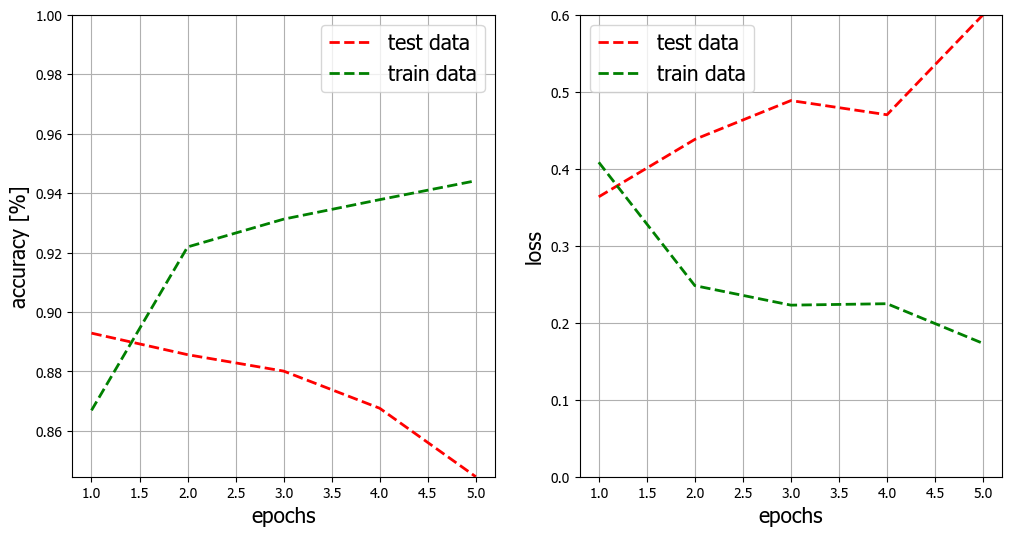

In [13]:


epochs = [ i+1 for i in range(epoch+1)]
fig, axs = plt.subplots(1,2, figsize =(12,6))
axs[0].plot(epochs,test_acc, label = 'test data' )
axs[0].plot(epochs, train_acc, label = 'train data')
axs[0].set_ylim(min(test_acc), 1)
axs[0].set_ylabel("accuracy [%]")
axs[0].legend()
axs[0].set_xlabel("epochs")
axs[0].grid()


axs[1].plot(epochs,test_loss, label = 'test data' )
axs[1].plot(epochs, train_loss, label = 'train data')
axs[1].set_ylim(0, max(test_loss))
axs[1].set_ylabel("loss")
axs[1].legend()
axs[1].set_xlabel("epochs")
axs[1].grid()

## Report 


In [14]:
from sklearn.metrics import classification_report


model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for inputs in test_dataloader:
        x, labels = inputs

        pred = model(x).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,digits=4, target_names = data_train.classes))

embed.shape torch.Size([100, 118, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 86, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 68, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 61, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 62, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 72, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 54, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 95, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 60, 32])
embed mean torch.

## Example 

embed.shape torch.Size([100, 118, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 86, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 68, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 61, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 62, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 72, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 54, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 95, 32])
embed mean torch.Size([100, 32])
h torch.Size([100, 64])
h torch.Size([100, 4])
embed.shape torch.Size([100, 60, 32])
embed mean torch.

/var/folders/zf/6v5q3x1x6rxd5grqb2fp2h3h0000gn/T/ipykernel_47942/49495933.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(nn_output)


(0.0, 1.0)

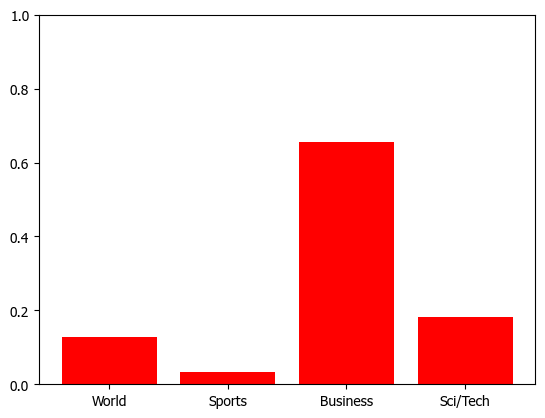

In [15]:

model.eval()
i_rand = np.random.randint(0, len(test_dataloader))

for i, inputs in enumerate(test_dataloader):
    x, labels = inputs
    y = model(x)    
    if i == i_rand:
        break 

rand_idx = np.random.randint(0, len(y))
nn_output = y[rand_idx]
probs = torch.nn.functional.softmax(nn_output)
cat_id = torch.argmax(probs)


#original data 
print("original review:\n",x_test[i*batch_size + rand_idx ])
print(f"\n vectorized review:\n", x_test_proc[i*batch_size+ rand_idx] )
label_or = data_train.classes[y_test[i*batch_size + rand_idx]-1]
label_rec = data_train.classes[cat_id]
print(f"\n label\n original:{label_or}\n predicted:{label_rec}", )

plt.bar(data_train.classes, probs.detach().numpy())
plt.ylim((0,1))
plt.xlabel("probability")





